In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import numpy as np
import pickle
import json
from utils import threshold_image
import os
from pipeline import Pipeline

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fname = 'test_images/straight_lines1.jpg'

In [3]:
# image = mpimg.imread(fname)
image = cv2.imread(fname)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [4]:
with open('parameters.json', 'r') as f:
    parameters = json.load(f)['adjusted']

# Undistorting

In [5]:
with open('camera.pkl', 'rb') as f:
    camera = pickle.load(f)

mtx, dist = camera['mtx'], camera['dist']

In [6]:
def undistort_image(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

In [7]:
image_undist = undistort_image(image)

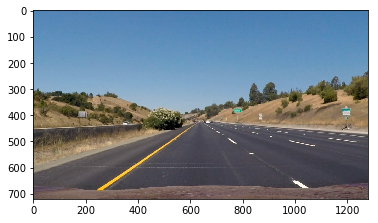

In [8]:
plt.imshow(image)

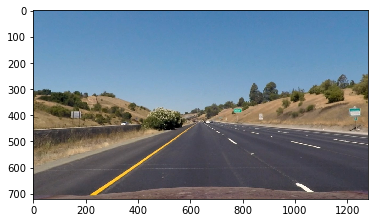

In [9]:
plt.imshow(image_undist)

In [ ]:
pipeline = 

# Thresholding

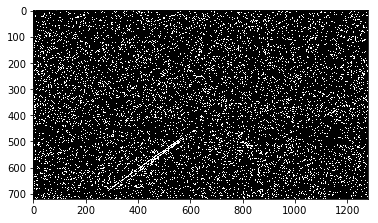

In [112]:
gradx_thresh = (parameters['sobel_x_thresh_min'], parameters['sobel_x_thresh_max'])
grady_thresh = (parameters['sobel_y_thresh_min'], parameters['sobel_y_thresh_max'])
magnitude_thresh = (parameters['mag_thresh_min'], parameters['mag_thresh_max'])
dir_thresh = (parameters['dir_thresh_min'], parameters['dir_thresh_max'])

gradient_threshold = threshold_image(image, ksize=parameters['sobel_kernel'], gradx_thresh=gradx_thresh,
                                     grady_thresh=grady_thresh, magnitude_thresh=magnitude_thresh,
                                     dir_thresh=dir_thresh)

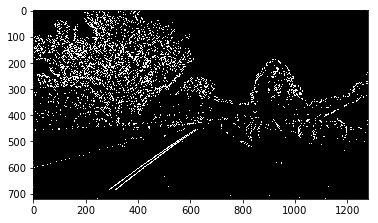

In [113]:
plt.imshow(gradient_threshold, cmap='gray')

In [114]:
image.shape

(720, 1280, 3)

In [115]:
image_hsl = cv2.cvtColor(image_undist, cv2.COLOR_RGB2HLS)

In [116]:
s_channel = image_hsl[:,:,2]

In [117]:
s_channel = cv2.medianBlur(s_channel, 5)

In [118]:
s_min = parameters['sat_thresh_min']
s_max = parameters['sat_thresh_max']
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_min) & (s_channel <= s_max)] = 1

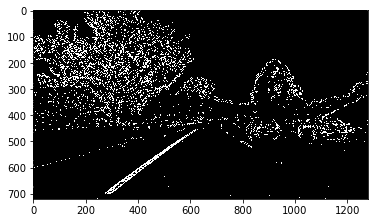

In [119]:
binary = np.zeros_like(gradient_threshold)
binary[(s_binary == 1) | (gradient_threshold == 1)] = 1
plt.imshow(binary, cmap='gray')

# Define ROI

In [25]:
imshape = image.shape

In [ ]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [ ]:
vertices = np.array([[(600, 400), (620, 400), (1150, imshape[0]), (180, imshape[0])]], dtype=np.int32)

In [ ]:
image_masked = region_of_interest(image_undist, vertices)

In [ ]:
plt.imshow(image_masked)

In [ ]:
def get_dest(src):
    (tl, tr, br, bl) = src
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    return dst

In [ ]:
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

In [ ]:
a = np.array([(600,400),(800,400),(imshape[1],620),(0,620)])

In [ ]:
s = a.sum(axis=1);s

In [ ]:
a[np.argmin(s)]

# Apply Perspective

In [26]:
# src_points = [(541,489),(747,489),(999,685),(253,685)]
src_points = [(600,445),(675,445),(1040,685),(253,685)]
# src_points = [(600,400),(800,400),(imshape[1],620),(0,620)]
src = np.array([src_points], dtype=np.float32)
dst = np.array([(350, 0), (950, 0), (950, imshape[0]), (350, imshape[0])], dtype=np.float32)
# dst = get_dest(src_points)

In [27]:
src, dst

(array([[[ 600.,  445.],
         [ 675.,  445.],
         [1040.,  685.],
         [ 253.,  685.]]], dtype=float32), array([[350.,   0.],
        [950.,   0.],
        [950., 720.],
        [350., 720.]], dtype=float32))

In [28]:
M = cv2.getPerspectiveTransform(src, dst)

In [101]:
M_inv = cv2.getPerspectiveTransform(dst, src)

In [140]:
M

array([[-4.81863204e-01, -1.53058493e+00,  9.49146701e+02],
       [-3.66373598e-15, -1.89613171e+00,  8.43778611e+02],
       [-4.77048956e-18, -2.38254584e-03,  1.00000000e+00]])

In [141]:
M_inv

array([[ 1.25000000e-01, -7.99846463e-01,  5.56250000e+02],
       [ 8.88178420e-16, -5.27389524e-01,  4.45000000e+02],
       [-4.33680869e-19, -1.25652972e-03,  1.00000000e+00]])

In [120]:
warped = cv2.warpPerspective(image_undist, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)

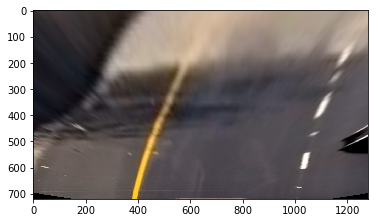

In [121]:
plt.imshow(warped)

In [122]:
binary_warped = cv2.warpPerspective(binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)

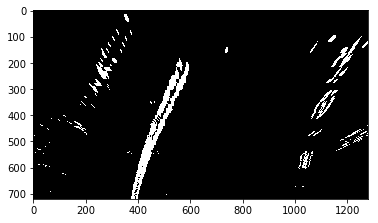

In [123]:
plt.imshow(binary_warped, cmap='gray')

In [124]:
mpimg.imsave('binary_warped.jpg', binary_warped)

In [125]:
hist = np.sum(binary_warped[imshape[0]//2:,:], axis=0)

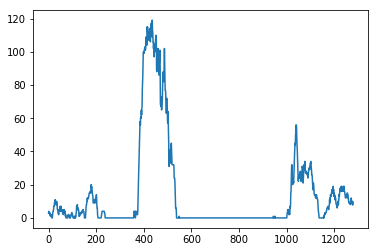

In [126]:
plt.plot(hist)

In [127]:
midpoint = hist.shape[0]//2

In [128]:
left_base = np.argmax(hist[:midpoint])

In [129]:
right_base = np.argmax(hist[midpoint:]) + midpoint

In [130]:
out_img = np.dstack([binary_warped, binary_warped, binary_warped]) * 255

In [131]:
n_windows = 9
window_height = imshape[0] // n_windows
margin = 100
minpix = 50

In [132]:
nonzero = binary_warped.nonzero()
nonzero_y = np.array(nonzero[0])
nonzero_x = np.array(nonzero[1])

left_lane_indices, right_lane_indices = [], []

In [133]:
leftx_current = left_base
rightx_current = right_base

In [134]:
for window in range(n_windows):
    window_y_low = imshape[0] - (window + 1) * window_height
    window_y_high = imshape[0] - window * window_height
    window_x_left_low = leftx_current - margin
    window_x_left_high = leftx_current + margin
    window_x_right_low = rightx_current - margin
    window_x_right_high = rightx_current + margin
    
    cv2.rectangle(out_img,(window_x_left_low, window_y_low), (window_x_left_high, window_y_high), (0, 255, 0), 2)
    cv2.rectangle(out_img,(window_x_right_low, window_y_low), (window_x_right_high, window_y_high), (0, 255, 0), 2)
    
    left_indices = ((nonzero_y >= window_y_low) & (nonzero_y < window_y_high) & 
     (nonzero_x >= window_x_left_low) & (nonzero_x <= window_x_left_high)).nonzero()[0]
    right_indices = ((nonzero_y >= window_y_low) & (nonzero_y < window_y_high) & 
     (nonzero_x >= window_x_right_low) & (nonzero_x <= window_x_right_high)).nonzero()[0]
        
    left_lane_indices.append(left_indices)
    right_lane_indices.append(right_indices)
    
    if (len(left_indices) > minpix):
        leftx_current = np.int(np.mean(nonzero_x[left_indices]))
    if (len(right_indices) > minpix):
        rightx_current = np.int(np.mean(nonzero_x[right_indices]))

In [135]:
left_lane_indices = np.concatenate(left_lane_indices)
right_lane_indices = np.concatenate(right_lane_indices)

leftx = nonzero_x[left_lane_indices]
lefty = nonzero_y[left_lane_indices]
rightx = nonzero_x[right_lane_indices]
righty = nonzero_y[right_lane_indices]

left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

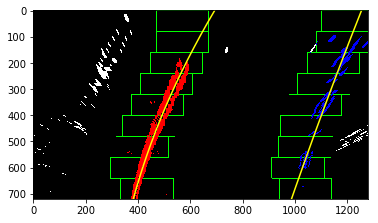

In [136]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzero_y[left_lane_indices], nonzero_x[left_lane_indices]] = [255, 0, 0]
out_img[nonzero_y[right_lane_indices], nonzero_x[right_lane_indices]] = [0, 0, 255]

fig, ax = plt.subplots( nrows=1, ncols=1 )
ax.imshow(out_img)
ax.plot(left_fitx, ploty, color='yellow')
ax.plot(right_fitx, ploty, color='yellow')
#ax.xlim(0, 1280)
#ax.ylim(720, 0)

In [137]:
fname_no_ext = os.path.splitext(os.path.split(fname)[-1])[0]
fig.savefig('{}_lines.jpg'.format(fname_no_ext))

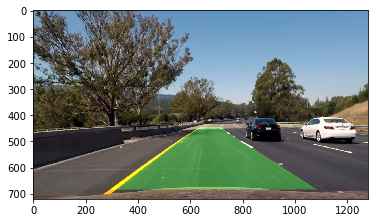

In [138]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, M_inv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image_undist, 1, newwarp, 0.3, 0)
plt.imshow(result)